In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree

import numpy as np
import haiku as hk
import src



In [2]:
####################################################################################
# Backflow transformation
class FermiNet_spin(hk.Module):
    def __init__(self, L, mask_flow):
        super().__init__()
        self.L = L
        self.mask_flow = mask_flow

    #========== Backflow ==========
    def backflow(self, x):
        def _fy(r):
            b, m = 2.6, 5.0
            fr = 0.5*(jnp.exp(-(b/r)**m)-1)
            return fr
        n, dim = x.shape
        x -= self.L * jnp.floor(x/self.L)
        rij = x[:, None, :] - x
        rij = rij - self.L*jnp.rint(rij/self.L)
        rij = rij[self.mask_flow].reshape(n, n-1, dim)
        dij = jnp.linalg.norm(rij, axis=-1)
        x = x + jnp.einsum('ij,ijd->id', _fy(dij), rij)
        return x

    #========== main ==========  
    def __call__(self, x):
        # Backflow:
        x = self.backflow(x)
        return x

In [3]:
####################################################################################
print("\n========== Initial parameters ==========")
key = jax.random.PRNGKey(42)
Emax = 1
twist = jnp.array([ 0, 0, 0])

batch = 8192
n, dim = 14, 3
nup, ndn = n//2, n//2
dens = 0.016355
L = (n/dens)**(1/3)
mc_steps, mc_stddev = 50, 0.1

num_devices = 1

2023-10-23 13:43:08.433276: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)



========== Initial parameters ==========


In [4]:
####################################################################################
print("\n========== Get orbitals ==========")
import src.orbitals
sp_indices, Es = src.sp_orbitals(dim, Emax)
num_states = Es.size
print("Number of available single-particle orbitals: %d" % num_states)
from scipy.special import comb
print("Total number of many-body states (%dup in %d) * (%ddown in %d): %d" 
      % (nup, num_states, ndn, num_states, comb(num_states, nup)**2) )
sp_indices_twist, Es_twist = src.twist_sort(sp_indices, twist)
del sp_indices, Es
sp_indices_twist, Es_twist = jnp.array(sp_indices_twist)[::-1], jnp.array(Es_twist)[::-1]


========== Get orbitals ==========
Number of available single-particle orbitals: 7
Total number of many-body states (7up in 7) * (7down in 7): 1


In [5]:
####################################################################################
print("\n========== Autoregressive model ==========")
import src.autoregressive
nlayers, modelsize, nheads, nhidden = 1, 1, 1, 1
def forward_fn(state_idx):
    model = src.autoregressive.Transformer(num_states, nlayers, modelsize, nheads, nhidden)
    return model(state_idx)
van = hk.transform(forward_fn)
state_idx_dummy = sp_indices_twist[-n:].astype(jnp.float64)
params_van = van.init(key, state_idx_dummy)

raveled_params_van, _ = ravel_pytree(params_van)
print("#parameters in the autoregressive model: %d" % raveled_params_van.size)

import src.sampler_spin
sampler, log_prob_novmap = src.sampler_spin.make_autoregressive_sampler_spin(van, 
                                        sp_indices_twist, nup, ndn, num_states)
log_prob = jax.vmap(log_prob_novmap, (None, 0), 0)


========== Autoregressive model ==========
#parameters in the autoregressive model: 37


In [6]:
####################################################################################
print("\n========== Flow model ==========")

mask_flow = ~jnp.eye(n, dtype=bool)
def flow_fn(x):
    model = FermiNet_spin(L, mask_flow)
    return model(x)
flow = hk.transform(flow_fn)
x_dummy = jax.random.uniform(key, (n, dim), minval=0., maxval=L)
params_flow = flow.init(key, x_dummy)

raveled_params_flow, _ = ravel_pytree(params_flow)
print("#parameters in the flow model: %d" % raveled_params_flow.size)

import src.logpsi_spin
logpsi_novmap = src.logpsi_spin.make_logpsi(flow, sp_indices_twist, L)
logphi, logjacdet = src.logpsi_spin.make_logphi_logjacdet(flow, sp_indices_twist, L)
logp = src.logpsi_spin.make_logp(logpsi_novmap)


========== Flow model ==========
#parameters in the flow model: 0


In [7]:
####################################################################################
print("\n========== MCMC Sample ==========")
batch_per_device = batch // num_devices
x = jax.random.uniform(key, (num_devices, batch_per_device, n, dim), minval=0., maxval=L)
keys = jax.random.split(key, num_devices)
x, keys = src.shard(x), src.shard(keys)
params_van, params_flow = src.replicate((params_van, params_flow), num_devices)


import src.VMC
for i in range(10):
    print("---- MCMC: %d ----" % (i+1))
    keys, _, x, accept_rate = src.VMC.sample_stateindices_and_x_mcmc(keys,
                            sampler, params_van,
                            logp, x, params_flow,
                            mc_steps, mc_stddev, L)


========== MCMC Sample ==========
---- MCMC: 1 ----
---- MCMC: 2 ----
---- MCMC: 3 ----
---- MCMC: 4 ----
---- MCMC: 5 ----
---- MCMC: 6 ----
---- MCMC: 7 ----
---- MCMC: 8 ----
---- MCMC: 9 ----
---- MCMC: 10 ----


In [8]:
x = x.reshape(-1, n, dim)
print("x", x.shape)

x (8192, 14, 3)


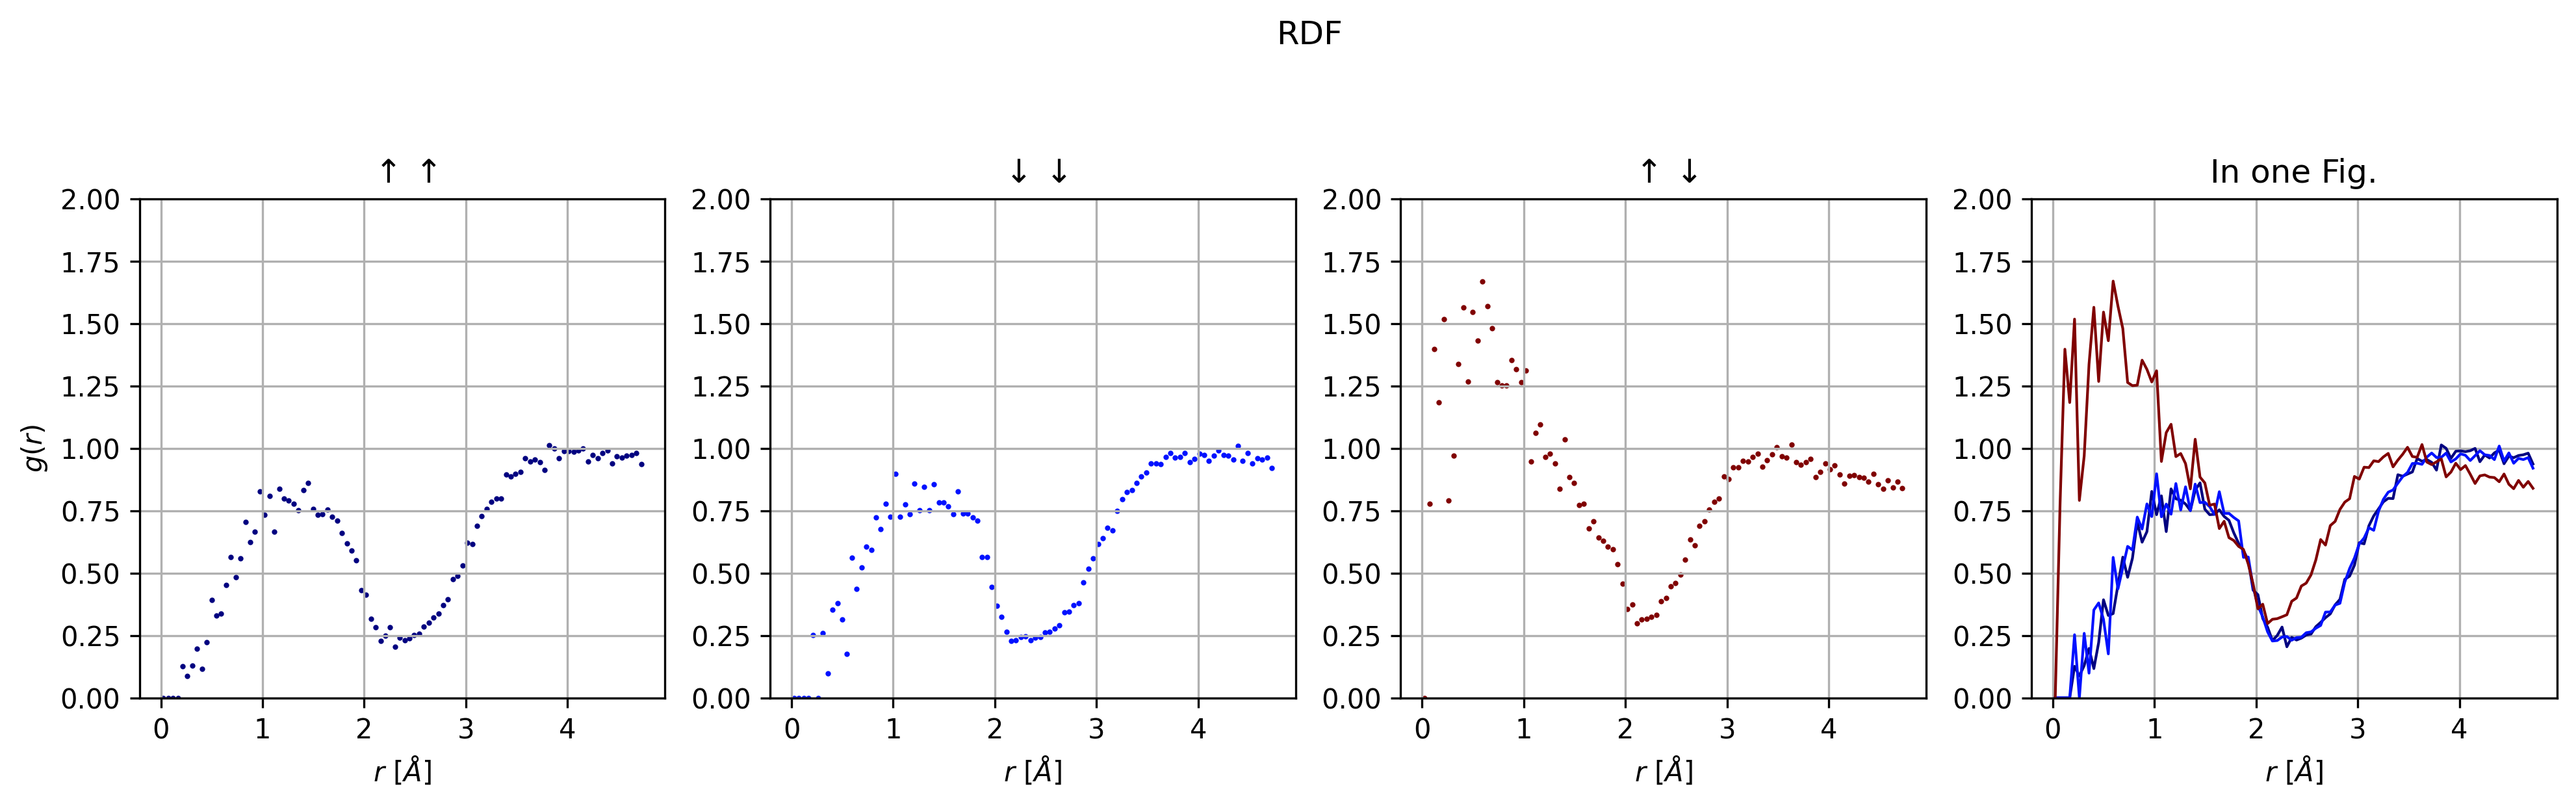

In [9]:
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.utils import get_gr, wrap_text, get_colors
colors = get_colors(8)
bins = 100

fig = plt.figure(figsize=(16, 4), dpi = 300)
ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)

miny, maxy = 0, 2.0

rmesh, gr = get_gr(x[:, :n//2], x[:, :n//2], L, bins)
#ax1.plot(rmesh, gr, ".-", linewidth=1, color=colors[0])
ax1.scatter(rmesh, gr, marker='o', s=1, color=colors[0])
ax1.set_xlabel(r"$r~[\AA]$")
ax1.set_ylabel(r"$g(r)$")
ax1.set_title(r"$\uparrow\uparrow$")
ax1.set_ylim([miny, maxy])
ax1.grid(1)

rmesh, gr = get_gr(x[:, n//2:], x[:, n//2:], L, bins)
#ax2.plot(rmesh, gr, ".-", linewidth=1, color=colors[1])
ax2.scatter(rmesh, gr, marker='o', s=1, color=colors[1])
ax2.set_xlabel(r"$r~[\AA]$")
#ax2.set_ylabel(r"$g(r)$")
ax2.set_title(r"$\downarrow\downarrow$")
ax2.set_ylim([miny, maxy])
ax2.grid(1)

rmesh, gr = get_gr(x[:, :n//2], x[:, n//2:], L, bins)
#ax3.plot(rmesh, gr, ".-", linewidth=1, color=colors[7])
ax3.scatter(rmesh, gr, marker='o', s=1, color=colors[7])
ax3.set_xlabel(r"$r~[\AA]$")
#ax3.set_ylabel(r"$g(r)$")
ax3.set_title(r"$\uparrow\downarrow$")
ax3.set_ylim([miny, maxy])
ax3.grid(1)

rmesh, gr = get_gr(x[:, :n//2], x[:, :n//2], L, bins)
ax4.plot(rmesh, gr, color=colors[0], linewidth=1, label=r"$\uparrow\uparrow$")
rmesh, gr = get_gr(x[:, n//2:], x[:, n//2:], L, bins)
ax4.plot(rmesh, gr, color=colors[1], linewidth=1, label=r"$\downarrow\downarrow$")
rmesh, gr = get_gr(x[:, :n//2], x[:, n//2:], L, bins)
ax4.plot(rmesh, gr, color=colors[7], linewidth=1, label=r"$\uparrow\downarrow$")
ax4.set_xlabel(r"$r~[\AA]$")
#ax4.set_ylabel(r"$g(r)$")
ax4.set_title("In one Fig.")
ax4.set_ylim([miny, maxy])
#ax4.legend()
ax4.grid(1)

title_str = "RDF"
plt.suptitle(title_str)
plt.subplots_adjust(top=0.75)

plt.show()